In [1]:
# Importar bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [2]:
# Configuración de estilo para gráficos Seaborn
sns.set(style="whitegrid")
plt.style.use('seaborn-darkgrid')

/tmp/ipykernel_19/2255778032.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


In [3]:
# Cargar datos
train_data = pd.read_csv('/kaggle/input/titanic-comp-data/train.csv')
test_data = pd.read_csv('/kaggle/input/titanic-comp-data/test.csv')

In [4]:
# Función para la limpieza de datos
def clean_data(df):
    df = df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
    df['Age'].fillna(df['Age'].median(), inplace=True)
    df['Fare'].fillna(df['Fare'].median(), inplace=True)
    df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)
    return df


In [5]:
# Limpieza de datos
train_data = clean_data(train_data)
test_data = clean_data(test_data)

In [6]:
# División en características (X) y variable objetivo (y)
X = train_data.drop('Survived', axis=1)
y = train_data['Survived']

In [7]:
# D# División del conjunto de entrenamiento
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Definir transformadores para características numéricas y categóricas
numeric_features = ['Age', 'SibSp', 'Parch', 'Fare']
categorical_features = ['Pclass', 'Sex', 'Embarked']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [9]:
# Combinar transformadores
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [10]:
# Definir el modelo
model = RandomForestClassifier(random_state=42)

In [11]:
# Crear el pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                             ('classifier', model)])

In [12]:
# Definir parámetros para búsqueda en cuadrícula
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
}

In [13]:
# Realizar búsqueda en cuadrícula para encontrar los mejores parámetros
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'SibSp',
                                                                          'Parch',
                                                                          'Fare']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Pclass',
                                                                          'Sex',
                                                                          'Embarked'])])),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'classifier__max_depth': [None, 10, 20],
                         'classifier__min_samples_leaf': [1, 2, 4],
                         'classifier__min_samples_split': [2, 5, 10],
                         'classifier__n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [14]:
# Obtener el mejor modelo
best_model = grid_search.best_estimator_

In [15]:
# Evaluación del modelo en el conjunto de prueba
y_pred = best_model.predict(X_test)

In [16]:
# Mostrar métricas de evaluación
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.8268156424581006
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.90      0.86       105
           1       0.83      0.73      0.78        74

    accuracy                           0.83       179
   macro avg       0.83      0.81      0.82       179
weighted avg       0.83      0.83      0.82       179

Confusion Matrix:
 [[94 11]
 [20 54]]


In [17]:
# Realizar predicciones en el conjunto de prueba (test.csv)
test_predictions = best_model.predict(test_data)

In [18]:
# Crear un archivo de salida con las predicciones
output = pd.DataFrame({'Survived': test_predictions})
output.to_csv('submission.csv', index=False)

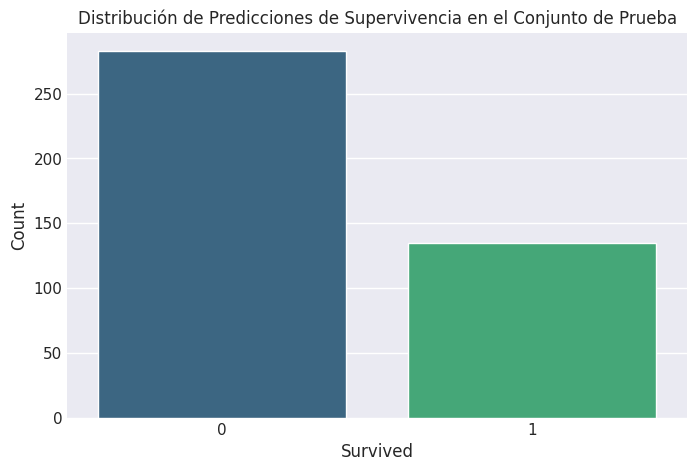

In [19]:
# Visualización de predicciones
plt.figure(figsize=(8, 5))
sns.countplot(data=output, x='Survived', palette='viridis')
plt.title('Distribución de Predicciones de Supervivencia en el Conjunto de Prueba')
plt.xlabel('Survived')
plt.ylabel('Count')
plt.show()